In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn

import matplotlib.pyplot as plt

# 1. define your dataloader

In [2]:
transform_list = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.131], std=[0.289])])
dataset = datasets.MNIST(root='/tmp/', train=True, download=True, transform=transform_list)
dataset = Subset(dataset, range(2000))

loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=500,
      shuffle=False)

# 2. define your model

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.flatten(1)

n_hidden = 2
hidden_size = 10
device = 'cuda'
layers = [Flatten(), nn.Linear(28 * 28, hidden_size), nn.ReLU()] + \
         [nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (n_hidden - 1) + \
         [nn.Linear(hidden_size, 10), nn.LogSoftmax(dim=1)]
model = nn.Sequential(*layers).to(device)

# 3. define your layer collection
The `LayerCollection` object defines the structure of the vectors that you will be manipulating. For example if you are interested in computing the FIM for the parameters of the first 2 layers, it will map these parameters to the part of the FIM that corresponds to these parameters.

In [4]:
from nngeometry.layercollection import LayerCollection

layer_collection = LayerCollection.from_model(model)

# EWC penalty

We now compute the matrices coefficients using the generator above. Using different representations we get different performances, and also we use more or less memory. But low memory footprint comes at the price of a less accurate approximation of the FIM, and so the gradient that we get from the penalty can be drastically different.

In [5]:
from nngeometry.object.pspace import PSpaceKFAC, PSpaceDiag, PSpaceBlockDiag, PSpaceDense
from nngeometry.object.vector import PVector
from nngeometry.metrics import FIM

Suppose we now train our model on task 1. We want to store the current state of the network using:
 1. the current parameter values `v1`
 2. the current Fisher Information Matrix `F_XXX`

In [6]:
v1 = PVector.from_model(model).clone().detach()

F_kfac = FIM(layer_collection=layer_collection,
             model=model,
             loader=loader,
             representation=PSpaceKFAC,
             n_output=10,
             variant='classif_logits',
             device='cuda')

F_blockdiag = FIM(layer_collection=layer_collection,
                  model=model,
                  loader=loader,
                  representation=PSpaceBlockDiag,
                  n_output=10,
                  variant='classif_logits',
                  device='cuda')

F_dense = FIM(layer_collection=layer_collection,
             model=model,
             loader=loader,
             representation=PSpaceDense,
             n_output=10,
             variant='classif_logits',
             device='cuda')


F_diag = FIM(layer_collection=layer_collection,
             model=model,
             loader=loader,
             representation=PSpaceDiag,
             n_output=10,
             variant='classif_logits',
             device='cuda')

In [7]:
n_parameters = F_kfac.generator.get_n_parameters()

We can now continue training, using an additional regularizer term, that uses the FIM and the difference betweem the current parameter value and `v1`

In [8]:
v_current = PVector.from_model(model)

you can now compute a regularizer scalar object and backward through it

In [9]:
regularizer_dense = F_dense.vTMv(v_current - v1)
regularizer_dense.backward()
[(p.size(), p.grad) for p in model.parameters()]

[(torch.Size([10, 784]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')),
 (torch.Size([10]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')),
 (torch.Size([10, 10]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')),
 (torch.Size([10]),
  tensor([0., 0., 

note that in this case all gradients stay at `0`, because `v_current = v1`, so for the purpose of this example, we will modify the value of `v_current`. You can think of this modification as resulting from SGD updates on the first iterations of training on task 2.

In [10]:
for p in model.parameters():
    p.data.add_(torch.randn_like(p))

We now recompute the gradients from the regularizer:

In [11]:
regularizer_dense = F_dense.vTMv(v_current - v1)
regularizer_dense.backward()
[(p.size(), p.grad) for p in model.parameters()]

[(torch.Size([10, 784]),
  tensor([[ 0.0074,  0.0074,  0.0074,  ...,  0.0074,  0.0074,  0.0074],
          [-0.0168, -0.0168, -0.0168,  ..., -0.0168, -0.0168, -0.0168],
          [ 0.0208,  0.0208,  0.0208,  ...,  0.0208,  0.0208,  0.0208],
          ...,
          [ 0.0460,  0.0460,  0.0460,  ...,  0.0460,  0.0460,  0.0460],
          [-0.0139, -0.0139, -0.0139,  ..., -0.0139, -0.0139, -0.0139],
          [ 0.0098,  0.0098,  0.0098,  ...,  0.0098,  0.0098,  0.0098]],
         device='cuda:0')),
 (torch.Size([10]),
  tensor([-0.0164,  0.0371, -0.0459,  0.0342,  0.0053, -0.0017,  0.0106, -0.1014,
           0.0307, -0.0217], device='cuda:0')),
 (torch.Size([10, 10]),
  tensor([[-7.7862e-06,  0.0000e+00, -7.7862e-05,  0.0000e+00, -8.7470e-05,
            0.0000e+00,  0.0000e+00, -3.0414e-05, -2.0426e-04, -6.5614e-06],
          [-1.8019e-02,  3.6289e-04, -8.7719e-04, -1.7464e-03, -2.7456e-02,
           -1.0408e-02, -6.3834e-03, -1.5726e-02, -1.5364e-02, -3.9678e-02],
          [ 3.7078e

# Comparison of regularization obtained using different representations

In [12]:
model.zero_grad()
regularizer_dense = F_dense.vTMv(v_current - v1)
regularizer_dense.backward()
g_dense = torch.cat([p.grad.view(-1) for p in model.parameters()])

In [13]:
model.zero_grad()
regularizer_bd = F_blockdiag.vTMv(v_current - v1)
regularizer_bd.backward()
g_bd = torch.cat([p.grad.view(-1) for p in model.parameters()])

In [14]:
model.zero_grad()
regularizer_kfac = F_kfac.vTMv(v_current - v1)
regularizer_kfac.backward()
g_kfac = torch.cat([p.grad.view(-1) for p in model.parameters()])

In [15]:
model.zero_grad()
regularizer_diag = F_diag.vTMv(v_current - v1)
regularizer_diag.backward()
g_diag = torch.cat([p.grad.view(-1) for p in model.parameters()])

Text(0.5, 1.0, 'Compare 100 elements of the gradient (first layer)')

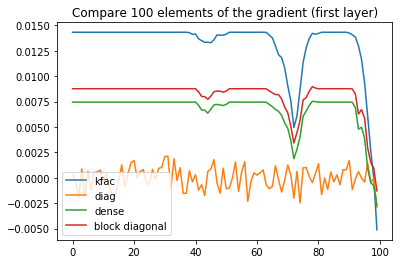

In [16]:
plt.plot(g_kfac[:100].cpu().numpy(), label='kfac')
plt.plot(g_diag[:100].cpu().numpy(), label='diag')
plt.plot(g_dense[:100].cpu().numpy(), label='dense')
plt.plot(g_bd[:100].cpu().numpy(), label='block diagonal')
plt.legend()
plt.title('Compare 100 elements of the gradient (first layer)')

Text(0.5, 1.0, 'Compare 100 elements of the gradient (last layer)')

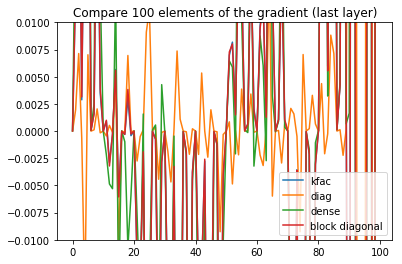

In [17]:
plt.plot(g_kfac[-100:].cpu().numpy(), label='kfac')
plt.plot(g_diag[-100:].cpu().numpy(), label='diag')
plt.plot(g_dense[-100:].cpu().numpy(), label='dense')
plt.plot(g_bd[-100:].cpu().numpy(), label='block diagonal')
plt.ylim(-.01, .01)
plt.legend()
plt.title('Compare 100 elements of the gradient (last layer)')